<a href="https://colab.research.google.com/github/mrch-hub/bangkit1/blob/test_feature_3/SolarPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Solar radiation intensity prediction using TensorFlow

In [0]:
"""A python code for predicting solar radiation
intensity using TensorFlow. Created for 
5th Bangk!t assignment.
Collaborators: Marcellinus Chrisnada, Muhammad
Harits Hafidza, Mochammad Randy Caesario H."""

'A python code for predicting solar radiation\nintensity using TensorFlow. Created for \n5th Bangk!t assignment.\nCollaborators: Marcellinus Chrisnada, Muhammad\nHarits Hafidza, Mochammad Randy Caesario H.'

##Initialization

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# Adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#@title Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/mrch-hub/bangkit1/master/SolarPrediction.csv')
data = data.reindex(np.random.permutation(data.index)) # shuffle dataset
data = data.rename(columns={'WindDirection(Degrees)':'WindDirection'})
data.head(15)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
11489,1476769820,10/17/2016 12:00:00 AM,19:50:20,1.2,53,30.5,100,137.9,10.1,06:18:00,17:58:00
23103,1478421302,11/5/2016 12:00:00 AM,22:35:02,1.2,49,30.5,29,176.8,6.8,06:26:00,17:46:00
1004,1474916720,9/26/2016 12:00:00 AM,09:05:20,687.0,57,30.4,66,83.0,9.0,06:12:00,18:15:00
32663,1480593003,12/1/2016 12:00:00 AM,01:50:03,1.2,43,30.4,100,180.8,10.1,06:41:00,17:42:00
15094,1475666724,10/5/2016 12:00:00 AM,01:25:24,1.2,51,30.4,102,144.4,1.1,06:14:00,18:08:00
...,...,...,...,...,...,...,...,...,...,...,...
18329,1479854103,11/22/2016 12:00:00 AM,12:35:03,500.5,48,30.4,102,83.1,6.8,06:35:00,17:42:00
15403,1475571018,10/3/2016 12:00:00 AM,22:50:18,1.3,51,30.4,99,69.5,3.4,06:14:00,18:09:00
8344,1477715423,10/28/2016 12:00:00 AM,18:30:23,1.2,45,30.4,100,110.3,5.6,06:22:00,17:51:00
4216,1473859508,9/14/2016 12:00:00 AM,03:25:08,2.1,48,30.4,94,192.2,1.1,06:10:00,18:26:00


##Adding some features to the dataset

In [0]:
#@title Adding feature is_daylight that define measurement time is either daylight (1) or nighttime (0)
is_daylight = [data['Time'].values[x] > data['TimeSunRise'].values[x] and data['Time'].values[x] < data['TimeSunSet'].values[x] for x in range(len(data))]
data['is_daylight'] = is_daylight
data['is_daylight'] = data['is_daylight'].astype('float')

In [0]:
#@title Convert UNIXTime into hour, day, month format
data['Time_Convert'] = pd.to_datetime(data['Time'], format = '%H:%M:%S')

data['Hour'] = pd.to_datetime(data['Time_Convert'], format = '%H:%M:%S').dt.hour # Get the hour of the day

data['Day'] = pd.to_datetime(data['UNIXTime'].astype(int), unit = 's').dt.day # Get the day of the month

data['Month'] = pd.to_datetime(data['UNIXTime'].astype(int), unit = 's').dt.month # Get the month of the year

##Data Preconditioning

In [6]:
#@title Splitting data to train set and test set
test_split = 0.2 # percentage of train set to be considered as test set
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]
print('train set length:', str(len(data_train)), '\ntest set length:', 
      str(len(data_test)))

train set length: 26149 
test set length: 6537


In [7]:
#@title Normalize values 

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train.select_dtypes(include=['float64', 'int64']).mean()
data_train_std = data_train.select_dtypes(include=['float64', 'int64']).std()
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                   - data_train_mean)/data_train_std

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test.select_dtypes(include=['float64', 'int64']).mean()
data_test_std = data_test.select_dtypes(include=['float64', 'int64']).std()
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                  - data_test_mean)/data_test_std

print("Normalized the values.")

Normalized the values.


## Represent data

The following code cell creates a feature layer containing 6 features:

* `Temperature`
* `Pressure`
* `is_daylight`
* `Humidity x Wind Cross Feature`
* `Hour x Month Cross Feature`
* `Day`

In [0]:
# Create empty feature column list
feature_columns = []

# Represent Temperature as a floating-point value.
temperature_numeric_column = tf.feature_column.numeric_column("Temperature")
#temperature_boundaries = list(np.arange(int(min(data_train['Radiation'])), int(max(data_train['Radiation']))))
#temperature = tf.feature_column.bucketized_column(temperature_numeric_column, temperature_boundaries)
feature_columns.append(temperature_numeric_column)

# Represent Pressure as a floating-point value.
pressure_numeric_column = tf.feature_column.numeric_column("Pressure")
#pressure_boundaries = list(np.arange(float(min(data_train['Pressure'])), float(max(data_train['Pressure']))))
#pressure = tf.feature_column.bucketized_column(pressure_numeric_column, pressure_boundaries)
feature_columns.append(pressure_numeric_column)

# Represent Humidity as a floating-point value.
humidity_numeric_column = tf.feature_column.numeric_column("Humidity")
humidity_boundaries = list(np.arange(int(min(data_train['Humidity'])), int(max(data_train['Humidity']))))
humidity = tf.feature_column.bucketized_column(humidity_numeric_column, humidity_boundaries)
#feature_columns.append(humidity)

# Represent Wind as a floating-point value.
wind_numeric_column = tf.feature_column.numeric_column("WindDirection")
wind_boundaries = list(np.arange(int(min(data_train['WindDirection'])), int(max(data_train['WindDirection']))))
wind = tf.feature_column.bucketized_column(wind_numeric_column, wind_boundaries)
#feature_columns.append(wind)

# Represent Daylight as a floating-point value.
daylight = tf.feature_column.numeric_column("is_daylight")
feature_columns.append(daylight)

# Represent Hour as a floating-point value.
day_numeric_column = tf.feature_column.numeric_column("Day")
#day_boundaries = list(np.arange(int(min(data_train['Day'])), int(max(data_train['Day']))))
#day = tf.feature_column.bucketized_column(day_numeric_column, day_boundaries)
feature_columns.append(day_numeric_column)

# Represent Hour as a floating-point value.
hour_numeric_column = tf.feature_column.numeric_column("Hour")
hour_boundaries = list(np.arange(int(min(data_train['Hour'])), int(max(data_train['Hour']))))
hour = tf.feature_column.bucketized_column(hour_numeric_column, hour_boundaries)
#feature_columns.append(hour_numeric_column)

# Represent Hour as a floating-point value.
month_numeric_column = tf.feature_column.numeric_column("Month")
month_boundaries = list(np.arange(int(min(data_train['Month'])), int(max(data_train['Month']))))
month = tf.feature_column.bucketized_column(month_numeric_column, month_boundaries)
#feature_columns.append(month_numeric_column)

# Create a feature cross between Temperature and Pressure
#temperature_x_pressure = tf.feature_column.crossed_column([temperature, pressure], hash_bucket_size=200)
#crossed_feature_TP = tf.feature_column.indicator_column(temperature_x_pressure)
#feature_columns.append(crossed_feature_TP)

# Create a feature cross between Humidity and Wind
humidity_x_wind = tf.feature_column.crossed_column([humidity, wind], hash_bucket_size=100)
crossed_feature_HW = tf.feature_column.indicator_column(humidity_x_wind)
feature_columns.append(crossed_feature_HW)

# Create a feature cross between Temperature and Day
#temperature_x_day = tf.feature_column.crossed_column([temperature, day], hash_bucket_size=400)
#crossed_feature = tf.feature_column.indicator_column(temperature_x_day)
#feature_columns.append(crossed_feature)

# Create a feature cross between Temperature and Hour
#temperature_x_hour = tf.feature_column.crossed_column([temperature, hour], hash_bucket_size=230)
#crossed_feature = tf.feature_column.indicator_column(temperature_x_hour)
#feature_columns.append(crossed_feature)

# Create a feature cross between Hour and Month
hour_x_month = tf.feature_column.crossed_column([hour, month], hash_bucket_size=100)
crossed_feature_HM = tf.feature_column.indicator_column(hour_x_month)
feature_columns.append(crossed_feature_HM)

# Create a feature cross between Hour, Day and Month
#hour_x_day_x_month = tf.feature_column.crossed_column([hour, day, month], hash_bucket_size=100)
#crossed_feature_HDM = tf.feature_column.indicator_column(hour_x_day_x_month)
#feature_columns.append(crossed_feature_HDM)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model

In [20]:
#@title Define plotting function

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mse_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mse_validation[1:], label="Validation Loss")
  plt.legend()

  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [21]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name,validation_split):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, 
                      shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/50
21/21 [==============================] - 0s 17ms/step - loss: 0.5607 - root_mean_squared_error: 0.7491 - val_loss: 0.4317 - val_root_mean_squared_error: 0.6504
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.3780 - root_mean_squared_error: 0.6148 - val_loss: 0.3750 - val_root_mean_squared_error: 0.6046
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.3439 - root_mean_squared_error: 0.5864 - val_loss: 0.3574 - val_root_mean_squared_error: 0.5896
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.3347 - root_mean_squared_error: 0.5785 - val_loss: 0.3546 - val_root_mean_squared_error: 0.5868
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.3327 - root_mean_squared_error: 0.5768 - val_loss: 0.3542 - val_root_mean_squared_error: 0.5864
Epoch 6/50
21/21 [==============================] - 0s 22ms/step - loss: 0.3331 - root_mean_squared_error: 0.5771 - val_loss: 0.3544 - val_root_mean_

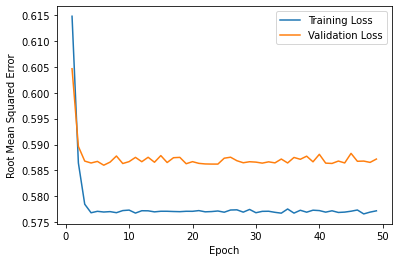


 Evaluate the linear regression model against the test set:
7/7 [==============================] - 0s 4ms/step - loss: 0.3409 - root_mean_squared_error: 0.5852


[0.3409383296966553, 0.5852130651473999]

In [24]:
#@title Train the model as linear regression
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 1000
validation_split = 0.2
label_name = "Radiation"
 

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, data_train_norm, epochs, batch_size, label_name, 
                          validation_split=validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)